# EMNIST

EMNIST es una extensión a MNIST donde involucra varios *datasets*, incluyendo la clasificación de caracteres alfabéticos. Es un problema intrínsecamente difícil, los mejores modelos no llegan a 96% según https://paperswithcode.com/sota/image-classification-on-emnist-letters. Además, es un problema práctico, puesto que es importante poder leer manuscritos a mano. Vamos a crear un modelo que pueda resolver, aunque no llegue al 96%.


In [155]:
from keras.utils import to_categorical
import keras
from keras import layers
from scipy import io as spio
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.callbacks import EarlyStopping

letters = "_ABCDEFGHIJKLMNOPQRSTUVWXYZ"


Cargamos el conjunto de datos, de la siguiente forma.

In [185]:
emnist = spio.loadmat('./datasets/emnist/emnist-letters.mat')

X_train = emnist['dataset'][0][0][0][0][0][0]
X_train = X_train.astype('float32')


y_train = emnist["dataset"][0][0][0][0][0][1]

X_test = emnist["dataset"][0][0][1][0][0][0]
X_test = X_test.astype('float32')

y_test = emnist["dataset"][0][0][1][0][0][1]

X_train = X_train.reshape(124800, 28, 28, 1)
X_test = X_test.reshape(20800, 28, 28, 1)

X_train = X_train / 255.0
X_test = X_test / 255.0

rotated_X_train = np.zeros_like(X_train)

for i in range(X_train.shape[0]):
    rotated_X_train[i] = np.fliplr(np.rot90(X_train[i], k=3))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Ahora visualizamos los datos.

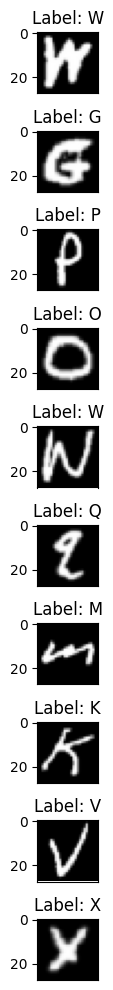

In [186]:
fig, axes = plt.subplots(10, 1, figsize=(10, 10))
for i, ax in enumerate(axes):
    ax.imshow(rotated_X_train[i, :, :, 0], cmap=plt.get_cmap('gray'))
    arg_max_label = np.argmax(y_train[i])
    title = f"Label: {letters[arg_max_label]}"
    ax.set_title(title)
    ax.get_xaxis().set_visible(False)
plt.tight_layout()
plt.show()


In [85]:
model = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(len(y_train[0]), activation="softmax"),
    ]
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 26, 26, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 24, 24, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │     1,982,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,135,003 (8.14 MB)

 Trainable params: 2,135,003 (8.14 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
results = model.fit(
    rotated_X_train,
    y_train,
    batch_size=128,
    epochs=50,
    callbacks=[early_stop],
    validation_data=(X_test, y_test))

Epoch 1/50
275/975 ━━━━━━━━━━━━━━━━━━━━ 2:08 184ms/step - accuracy: 0.6870 - loss: 1.2284

In [88]:
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

650/650 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9367 - loss: 0.2034
Test loss: 0.20918972790241241
Test accuracy: 0.9314423203468323


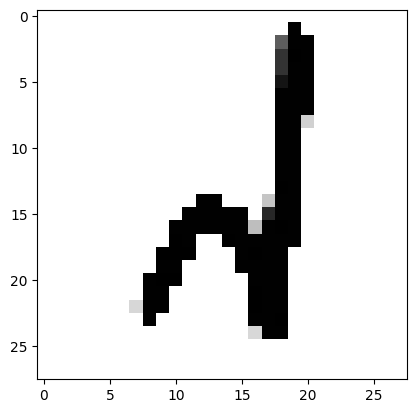

In [113]:
test_img = np.random.randn(1, 28, 28, 1)
test_img = cv2.imread('./datasets/emnist/h_letter.png', cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (28, 28))
test_img = cv2.flip(test_img, 1)
# test_img = cv2.rotate(test_img, cv2.ROTATE_90_CLOCKWISE)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
plt.imshow(test_img, cmap='gray')

In [114]:
test_img = test_img / 255.0
test_img = np.resize(test_img, (1, 28, 28, 1))


In [116]:
prediction = model.predict(test_img, verbose=1)
print(prediction)
print(np.argmax(prediction) + 1)
print(f"Predicted value: {letters[np.argmax(prediction) + 1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[3.21212987e-11 5.02042647e-04 2.84019560e-01 1.59599185e-05
  7.51545129e-04 1.00701014e-02 1.62017768e-05 6.69639885e-01
  1.77266386e-07 2.74289141e-05 7.34267530e-07 4.03937120e-05
  8.76277045e-06 2.07782409e-06 7.32409897e-11 1.10902015e-07
  2.08694155e-06 5.42337424e-04 2.68953918e-05 3.39406319e-02
  2.27116237e-09 5.61401592e-08 4.69061845e-10 1.38640826e-04
  4.59541070e-07 3.15268892e-07 2.53631122e-04]]
8
Predicted value: H


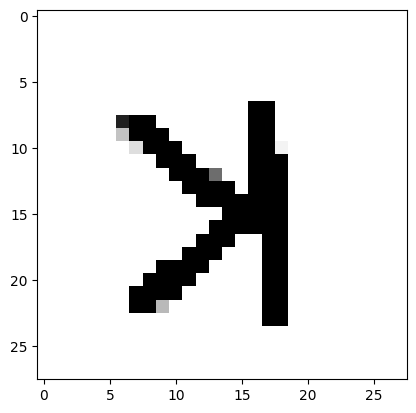

In [95]:
test_img2 = np.random.randn(1, 28, 28, 1)
test_img2 = cv2.imread('./datasets/emnist/k_letter.png', cv2.IMREAD_COLOR)
test_img2 = cv2.resize(test_img2, (28, 28))
test_img2 = cv2.flip(test_img2, 1)
# test_img = cv2.rotate(test_img, cv2.ROTATE_90_CLOCKWISE)
test_img2 = cv2.cvtColor(test_img2, cv2.COLOR_BGR2GRAY)
plt.imshow(test_img2, cmap='gray')

In [118]:
test_img2 = test_img2 / 255.0
test_img2 = np.resize(test_img2, (1, 28, 28, 1))

In [119]:
prediction = model.predict(test_img2, verbose=1)
print(prediction)
print(np.argmax(prediction) + 1)
print(f"Predicted value: {letters[np.argmax(prediction) + 1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[0.03423411 0.03728537 0.03424774 0.04070907 0.03633776 0.03689696
  0.03665306 0.03639539 0.0367009  0.04386426 0.03998048 0.03312466
  0.04301118 0.03030533 0.03805447 0.0372949  0.03688819 0.03541451
  0.03959311 0.03718696 0.0380518  0.03634514 0.03893517 0.0325501
  0.03605726 0.03734009 0.03654201]]
10
Predicted value: K


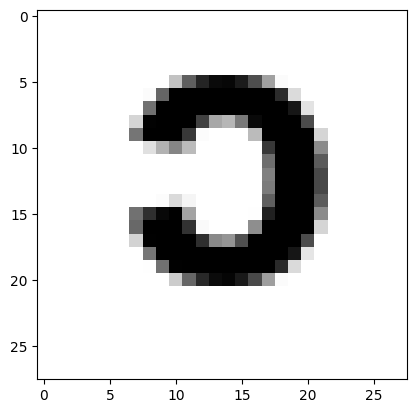

In [120]:
test_img3 = None
test_img3 = cv2.imread('./datasets/emnist/c_letter.png', cv2.IMREAD_COLOR)
test_img3 = cv2.resize(test_img3, (28, 28))
test_img3 = cv2.flip(test_img3, 1)
# test_img = cv2.rotate(test_img, cv2.ROTATE_90_CLOCKWISE)
test_img3 = cv2.cvtColor(test_img3, cv2.COLOR_BGR2GRAY)
plt.imshow(test_img3, cmap='gray')

In [121]:
test_img3 = test_img3 / 255.0
test_img3 = np.resize(test_img3, (1, 28, 28, 1))

In [122]:
prediction = model.predict(test_img3, verbose=1)
print(prediction)
print(np.argmax(prediction) + 1)
print(f"Predicted value: {letters[np.argmax(prediction) + 1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[5.6852141e-08 9.8470272e-03 2.0311479e-03 1.4313313e-04 3.4922946e-03
  1.1667617e-03 1.8002808e-06 1.6445366e-01 1.6312117e-06 4.0881869e-08
  7.2337839e-06 3.5418861e-08 3.2463529e-07 1.2087276e-02 1.5413104e-06
  5.6278747e-02 8.9090544e-04 7.4300349e-01 4.0849172e-06 4.2994605e-05
  4.5322437e-07 2.4533920e-05 6.1175961e-06 6.4781443e-03 9.7516327e-08
  9.5644245e-06 2.6911184e-05]]
18
Predicted value: S
